**Project Description**

Transport for London (TfL) is a vast public transport network that allows London's residents to efficiently travel around the UK's capital, to the tune of over 1.5 million journeys per day!


**Complete Workflow:**

*    Load and Prepare Data
*    Feature Engineering
*    Model Evaluation
*    Hyperparameter Tuning
*    Final Model Evaluation and Visualization



In [156]:
# Install packages
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install statsmodels
!pip install seaborn
!pip install xgboost
!pip install catboost

In [279]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [280]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

Saving tfl_journeys_final.csv to tfl_journeys_final (8).csv


In [281]:
# Read the dataset
df = pd.read_csv('tfl_journeys_final.csv')

# Display the first few rows of the dataframe
df.head()

,month,year,days,report_date,journey_type,journeys_millions
0,1,2010,31,06/30/2010,Underground & DLR,96.836391
1,2,2010,28,06/30/2010,Underground & DLR,90.330504
2,3,2010,31,06/30/2010,Underground & DLR,90.038014
3,4,2010,30,09/30/2010,Underground & DLR,92.544093
4,5,2010,31,09/30/2010,Underground & DLR,88.662911


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              936 non-null    int64  
 1   year               936 non-null    int64  
 2   days               936 non-null    int64  
 3   report_date        936 non-null    object 
 4   journey_type       936 non-null    object 
 5   journeys_millions  841 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 44.0+ KB


The dataset contains the following columns:

    month: Month of the year.
    year: Year of the record.
    days: Number of days in the month.
    report_date: Date when the report was generated.
    journey_type: Type of journey (e.g., Underground & DLR).
    journeys_millions: Number of journeys in millions.


From the output, we see that all columns except 'journeys_millions' have 936 non-null entries.
'journeys_millions' has 841 non-null entries, indicating that there are 95 missing values in this column.

In [283]:
# Summary statistics
tfl_summary_stats = df.describe()
print(tfl_summary_stats)

            month         year        days  journeys_millions
count  936.000000   936.000000  936.000000         841.000000
mean     6.500000  2016.000000   30.435897          50.336615
std      3.453898     3.743658    0.818342          65.659930
min      1.000000  2010.000000   28.000000           0.000169
25%      3.750000  2013.000000   30.000000           2.133444
50%      6.500000  2016.000000   31.000000           9.780669
75%      9.250000  2019.000000   31.000000         105.064674
max     12.000000  2022.000000   31.000000         203.398289


In [284]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

month                 0
year                  0
days                  0
report_date           0
journey_type          0
journeys_millions    95
dtype: int64


From the output above, we see that the missing values in the dataset are concentrated in the journeys_millions column, with 95 missing entries.

To handle the missing data, we will use interpolation.

**Why?**

Interpolation is used to handle missing values in the dataset by estimating values within the range of existing data points.

In the context of the journeys_millions column, interpolation helps in maintaining the continuity and trends in the data without introducing biases that might occur with other imputation methods like mean or median imputation.

In [285]:
# Interpolate missing values in the 'journeys_millions' column
df['journeys_millions'] = df['journeys_millions'].interpolate()

# Verify if there are any remaining missing values
missing_values_after_interpolation = df.isnull().sum()
print(missing_values_after_interpolation)

month                0
year                 0
days                 0
report_date          0
journey_type         0
journeys_millions    0
dtype: int64


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              936 non-null    int64  
 1   year               936 non-null    int64  
 2   days               936 non-null    int64  
 3   report_date        936 non-null    object 
 4   journey_type       936 non-null    object 
 5   journeys_millions  936 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 44.0+ KB


In [287]:
# Convert report_date to Datetime
df['report_date'] = pd.to_datetime(df['report_date'])

**Univariate Analysis**

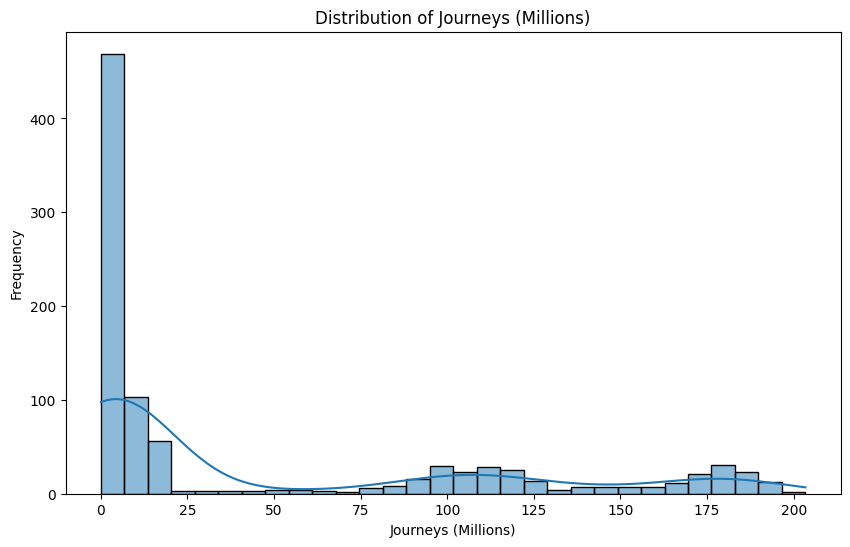

In [288]:
plt.figure(figsize=(10, 6))
sns.histplot(df['journeys_millions'], bins=30, kde=True)
plt.title('Distribution of Journeys (Millions)')
plt.xlabel('Journeys (Millions)')
plt.ylabel('Frequency')
plt.show()

**Bivariate Analysis**

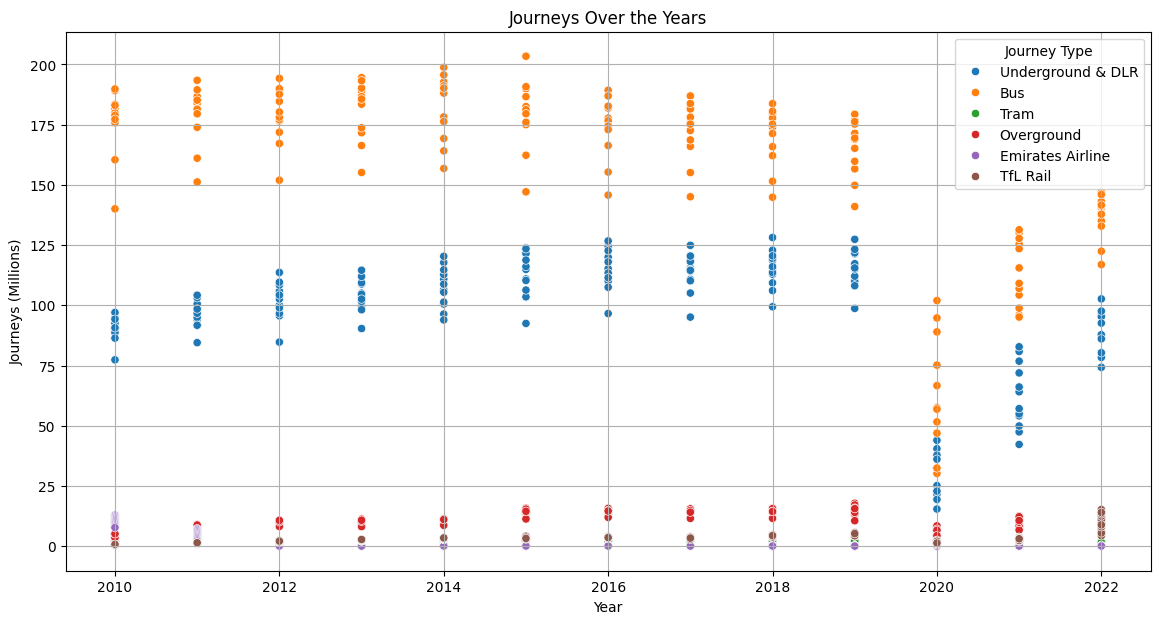

In [289]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='year', y='journeys_millions', hue='journey_type')
plt.title('Journeys Over the Years')
plt.xlabel('Year')
plt.ylabel('Journeys (Millions)')
plt.legend(title='Journey Type')
plt.grid(True)
plt.show()

**Time Series Analysis**

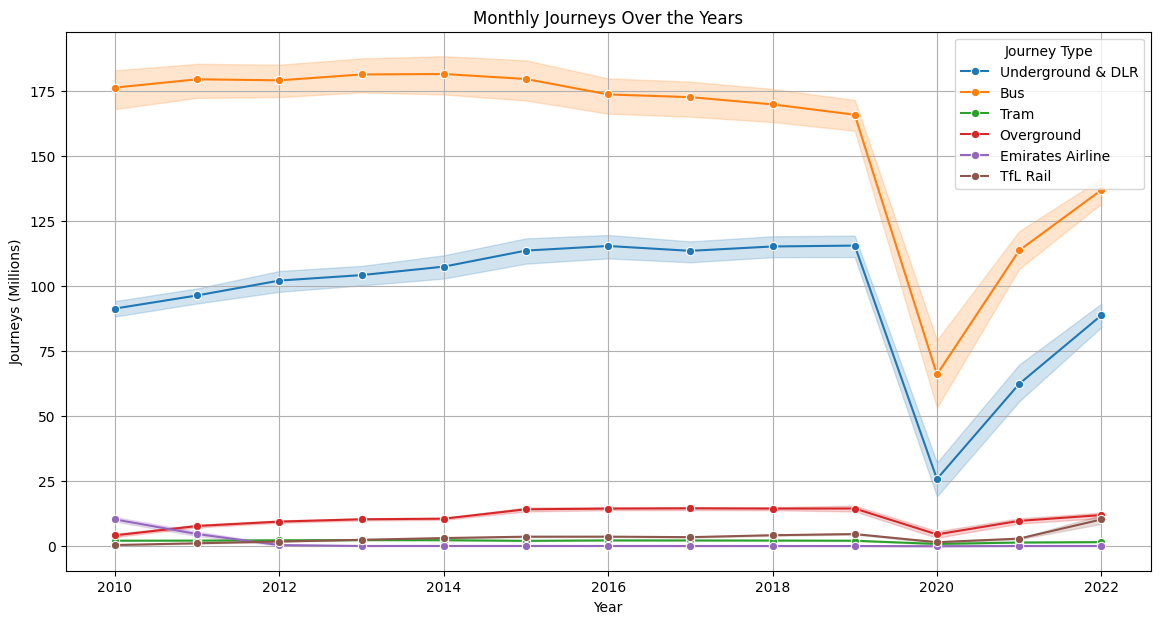

In [290]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='year', y='journeys_millions', hue='journey_type', marker='o')
plt.title('Monthly Journeys Over the Years')
plt.xlabel('Year')
plt.ylabel('Journeys (Millions)')
plt.legend(title='Journey Type')
plt.grid(True)
plt.show()

**Correlation Analysis**

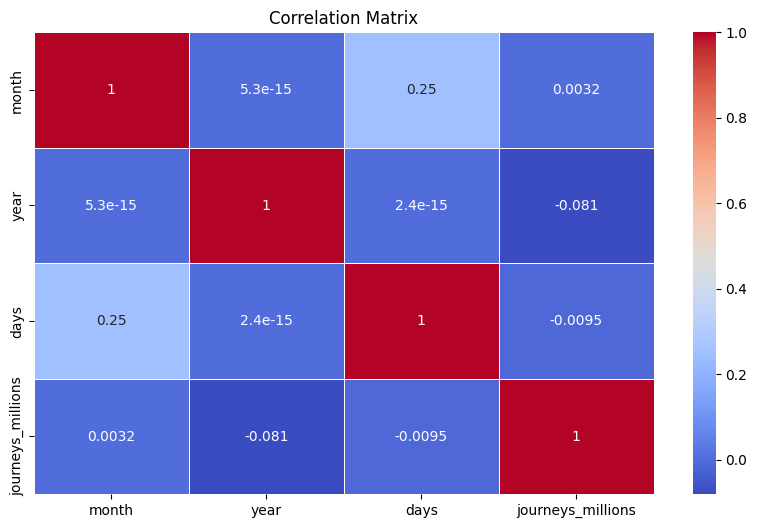

In [291]:
# Compute correlation matrix only for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_cols.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

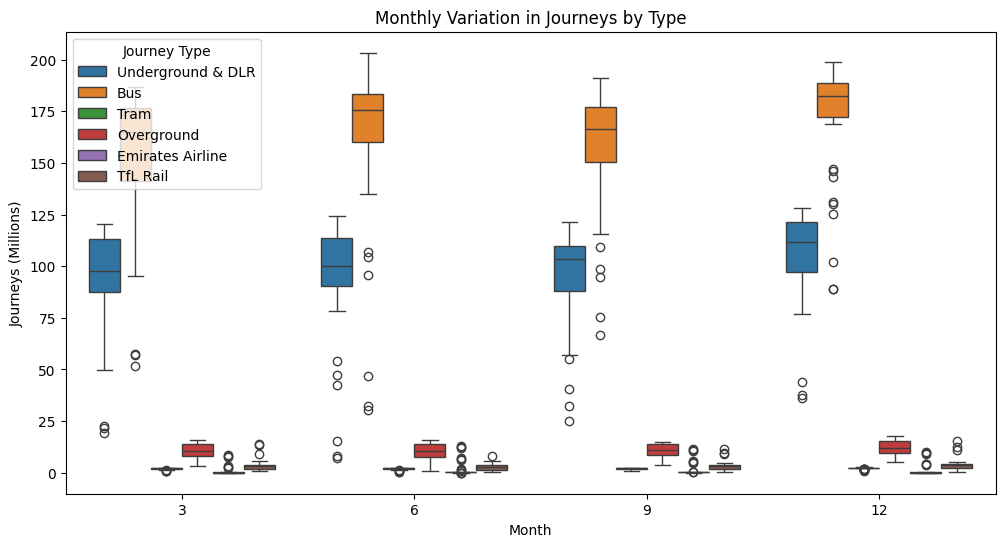

In [292]:
# Monthly variation in journeys by journey type
df['month'] = df['report_date'].dt.month
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='journeys_millions', hue='journey_type')
plt.title('Monthly Variation in Journeys by Type')
plt.xlabel('Month')
plt.ylabel('Journeys (Millions)')
plt.legend(title='Journey Type')
plt.show()

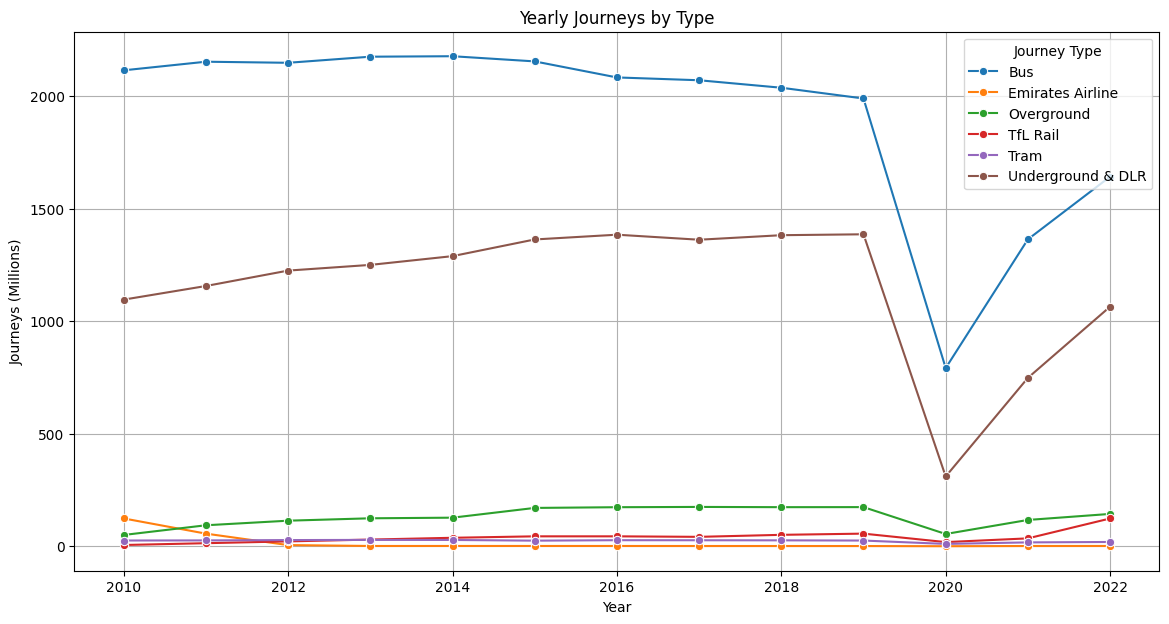

In [293]:
# Yearly Trends Analysis: Yearly journeys by journey type
yearly_data = df.groupby(['year', 'journey_type']).agg({'journeys_millions': 'sum'}).reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=yearly_data, x='year', y='journeys_millions', hue='journey_type', marker='o')
plt.title('Yearly Journeys by Type')
plt.xlabel('Year')
plt.ylabel('Journeys (Millions)')
plt.legend(title='Journey Type')
plt.grid(True)
plt.show()

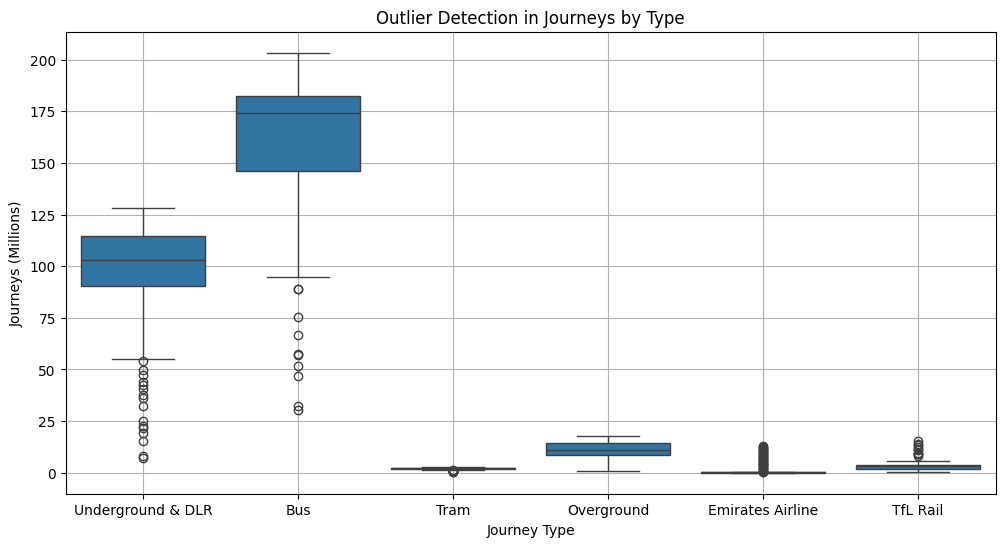

In [296]:
# Outlier Detection: Boxplot of journeys by journey type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='journey_type', y='journeys_millions')
plt.title('Outlier Detection in Journeys by Type')
plt.xlabel('Journey Type')
plt.ylabel('Journeys (Millions)')
plt.grid(True)
plt.show()

In [295]:
# Aggregated Statistics - Mean, median, and standard deviation for each journey type
aggregated_stats = df.groupby('journey_type').agg({
    'journeys_millions': ['mean', 'median', 'std', 'min', 'max']
}).reset_index()
aggregated_stats.columns = ['Journey Type', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max']
print(aggregated_stats)

        Journey Type        Mean      Median  Standard Deviation        Min  \
0                Bus  159.648679  174.169122           35.771889  30.223736   
1   Emirates Airline    1.270439    0.118584            2.961015   0.000169   
2         Overground   10.847968   10.974634            3.803801   0.999693   
3           TfL Rail    3.363538    3.217023            2.523669   0.172614   
4               Tram    2.017243    2.173180            0.457308   0.440934   
5  Underground & DLR   96.285042  102.899275           26.398172   6.950757   

          Max  
0  203.398289  
1   12.895456  
2   17.820632  
3   15.223201  
4    2.638906  
5  128.155995  


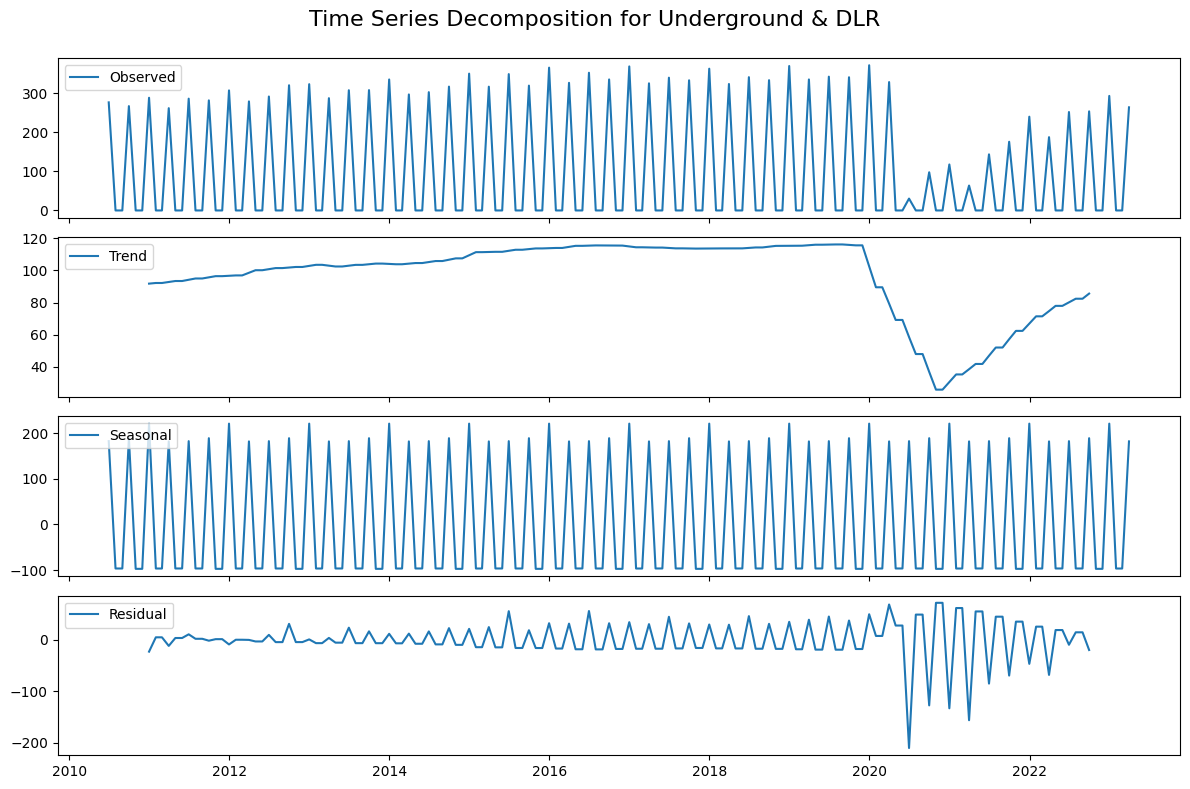

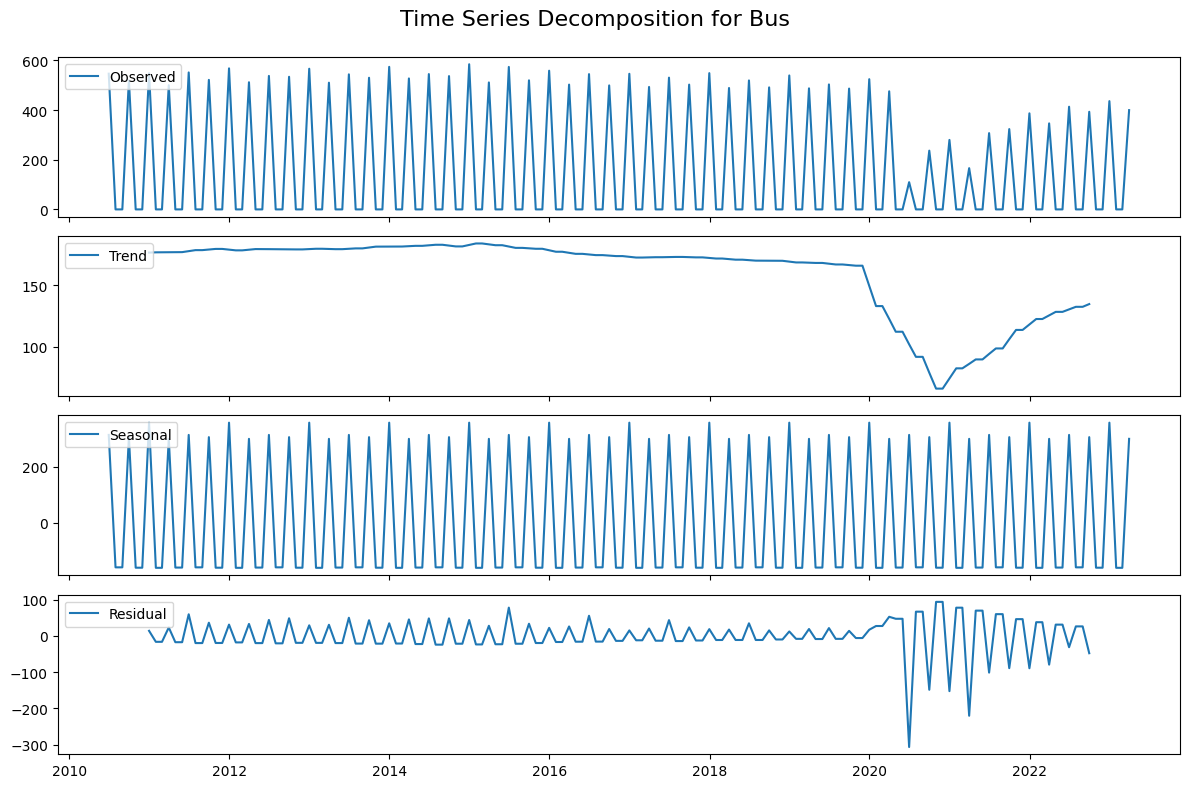

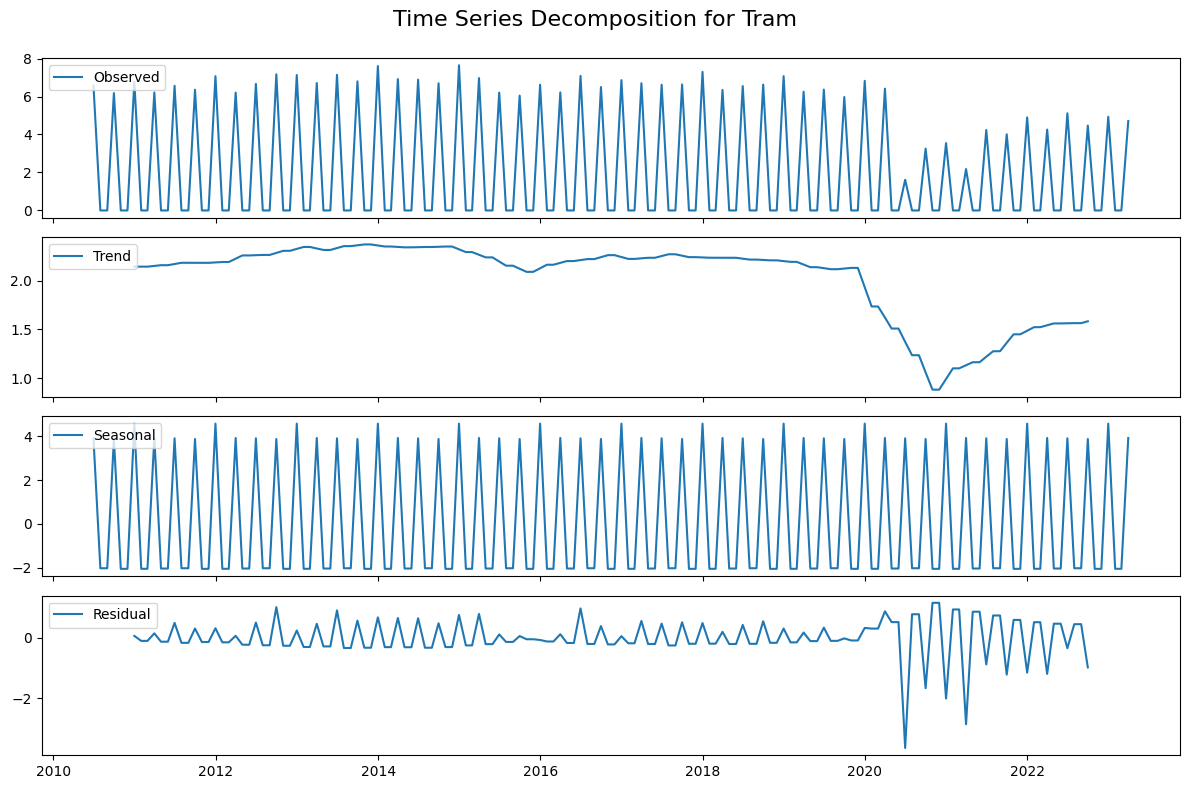

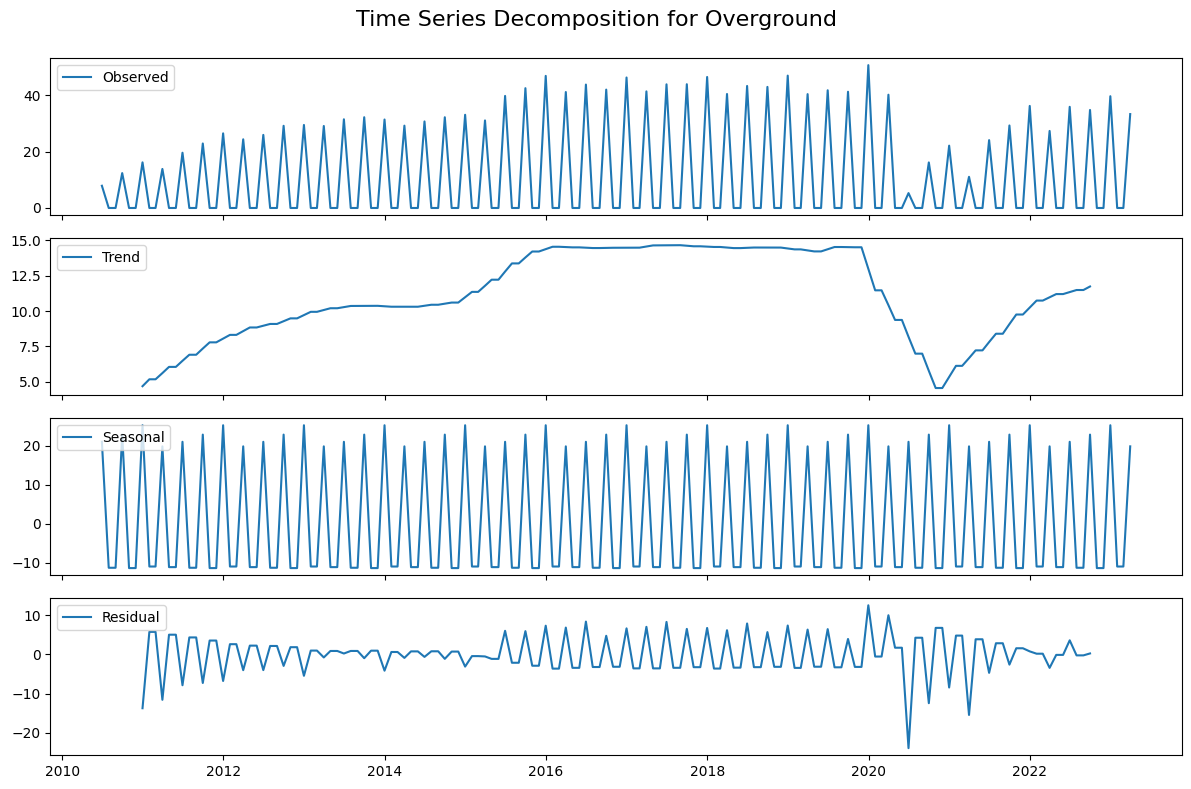

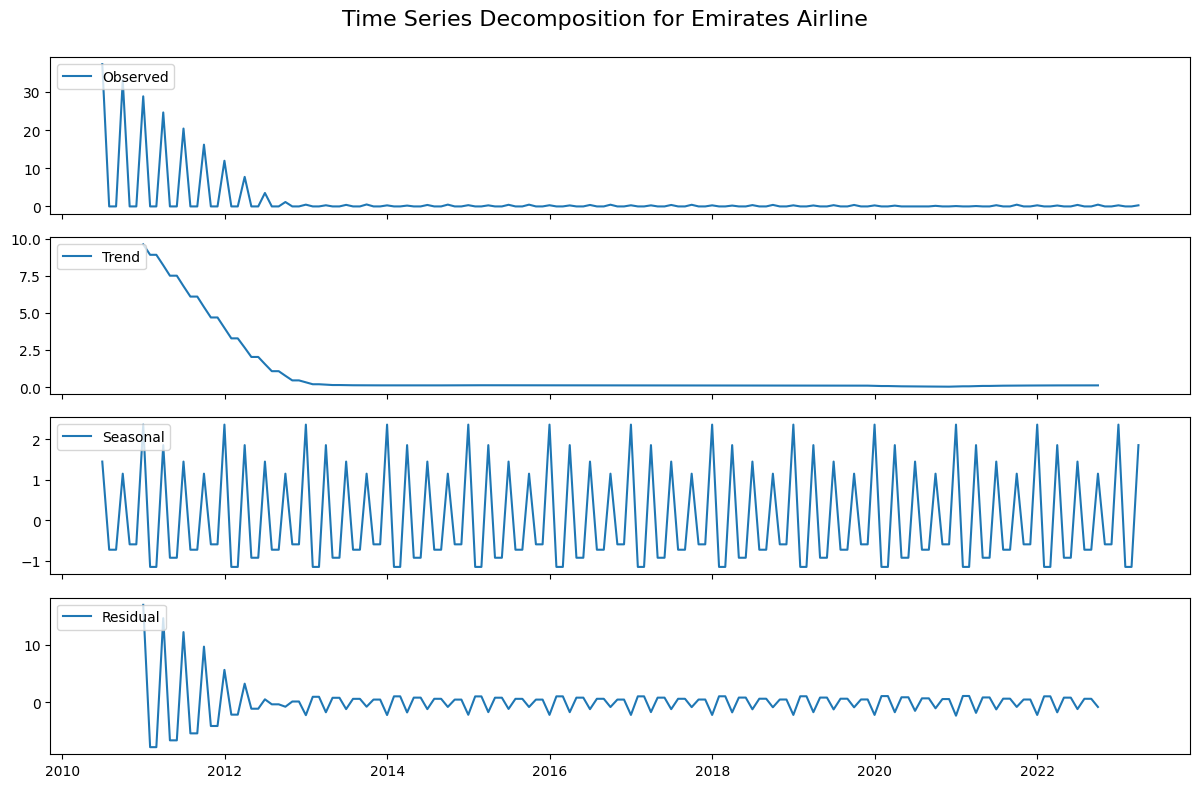

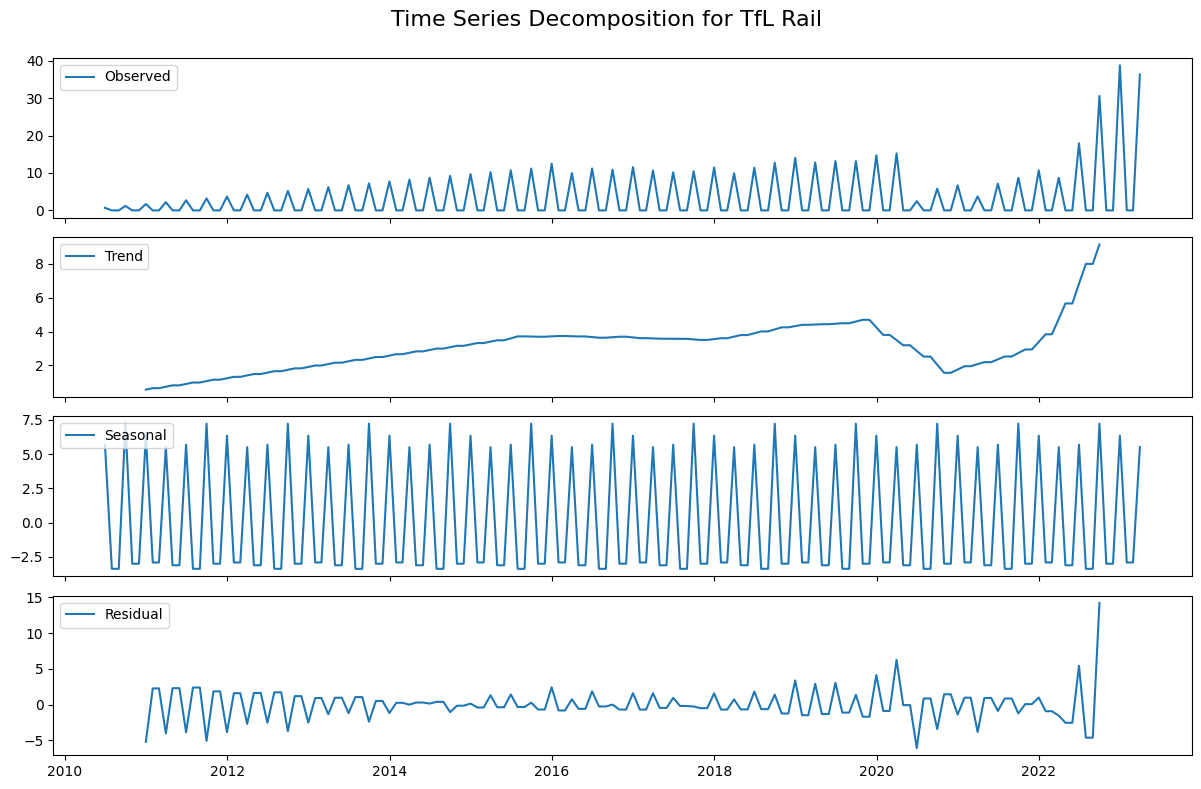

In [297]:
# Time Series Decomposition: Trend, seasonality, and residuals for each journey type
for journey_type in df['journey_type'].unique():
    journey_data = df[df['journey_type'] == journey_type]
    journey_data.set_index('report_date', inplace=True)
    journey_data = journey_data['journeys_millions'].resample('M').sum()

    decomposition = seasonal_decompose(journey_data, model='additive')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    ax1.plot(decomposition.observed, label='Observed')
    ax1.legend(loc='upper left')

    ax2.plot(decomposition.trend, label='Trend')
    ax2.legend(loc='upper left')

    ax3.plot(decomposition.seasonal, label='Seasonal')
    ax3.legend(loc='upper left')

    ax4.plot(decomposition.resid, label='Residual')
    ax4.legend(loc='upper left')

    fig.suptitle(f'Time Series Decomposition for {journey_type}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

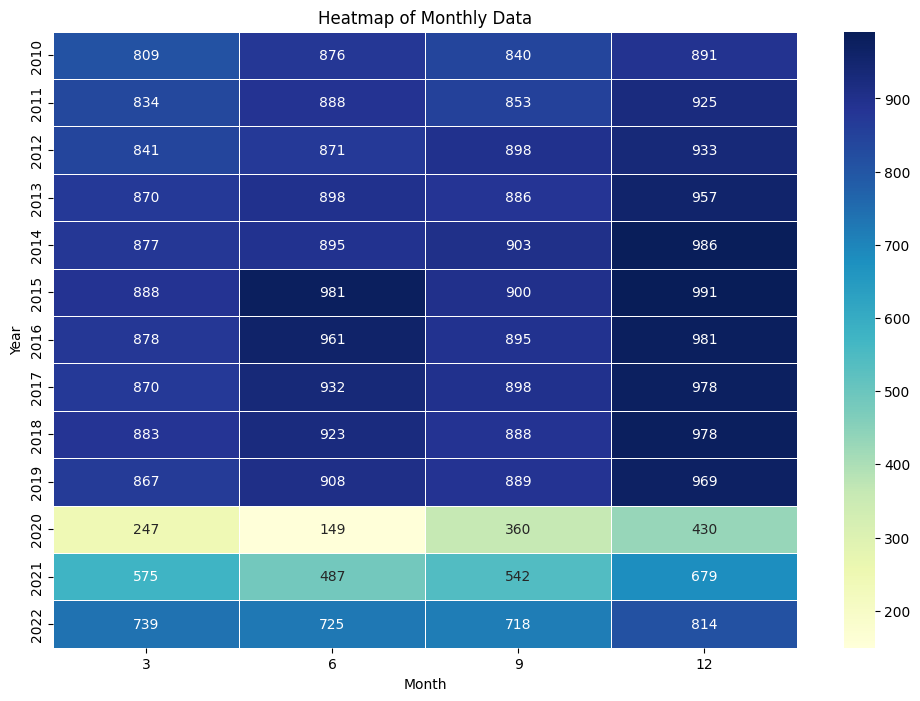

In [300]:
# Visualize the number of journeys over the months and years
pivot_table = df.pivot_table(
    values='journeys_millions',
    index='year',
    columns='month',
    aggfunc='sum'
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)
plt.title('Heatmap of Monthly Data')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

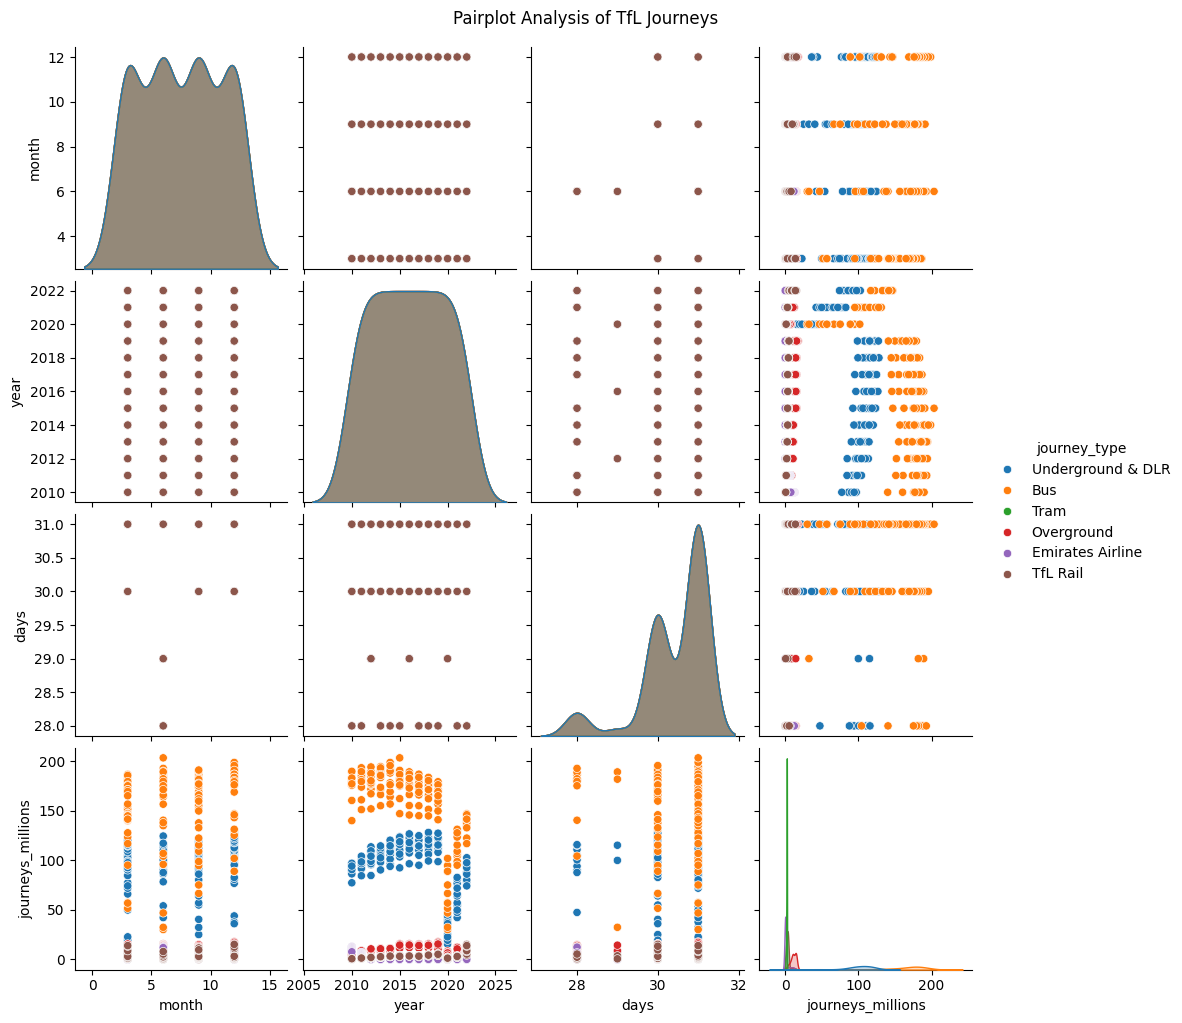

In [302]:
# Visualize pairwise relationships in the dataset
sns.pairplot(df, hue='journey_type')
plt.suptitle('Pairplot Analysis of TfL Journeys', y=1.02)
plt.show()

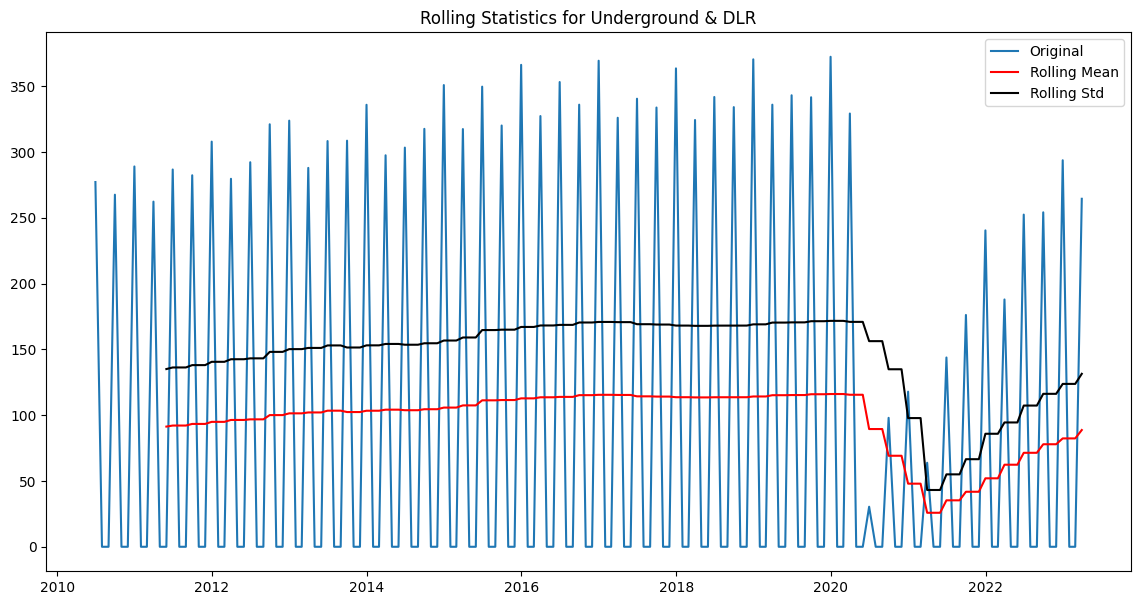

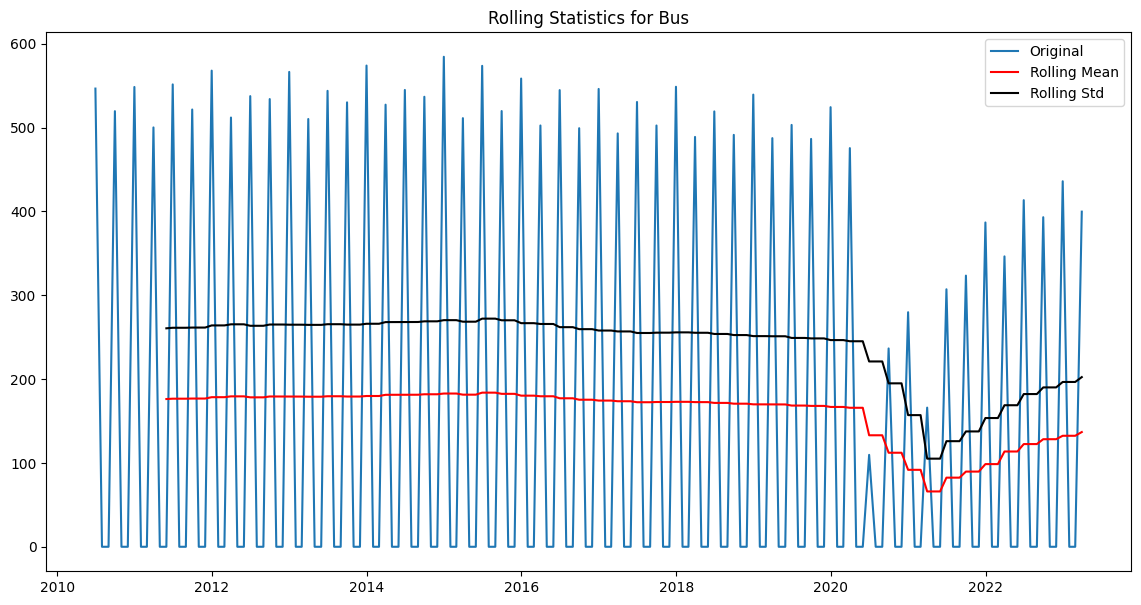

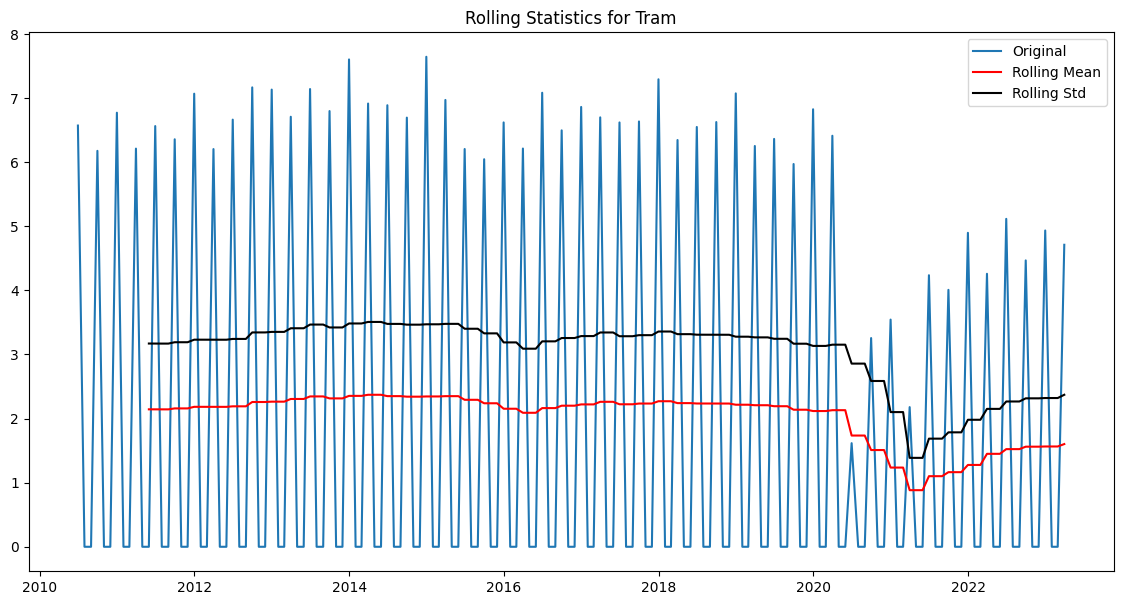

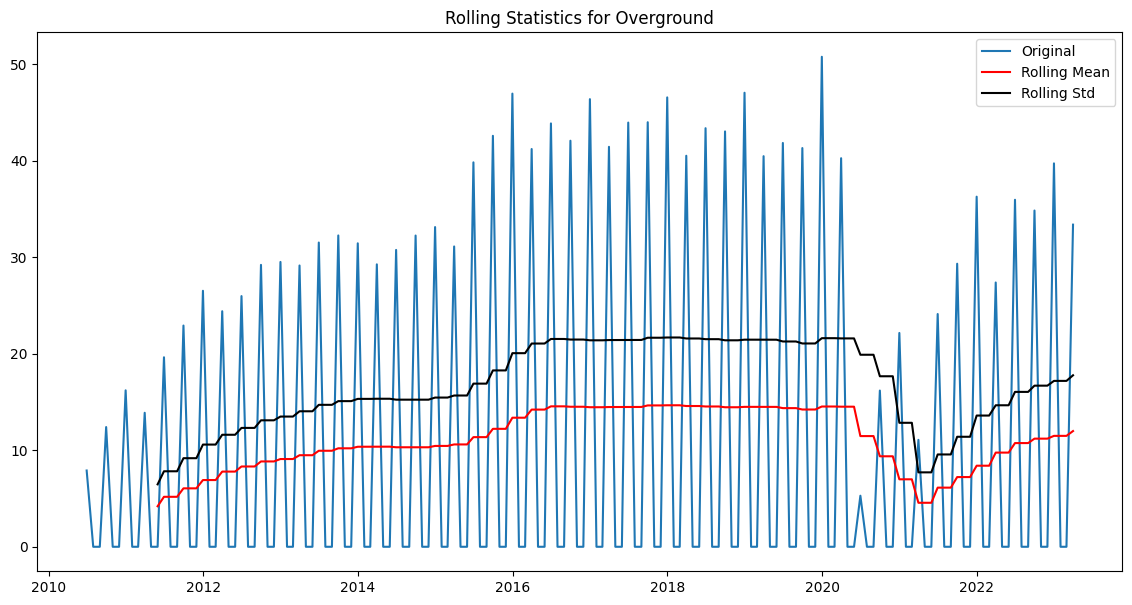

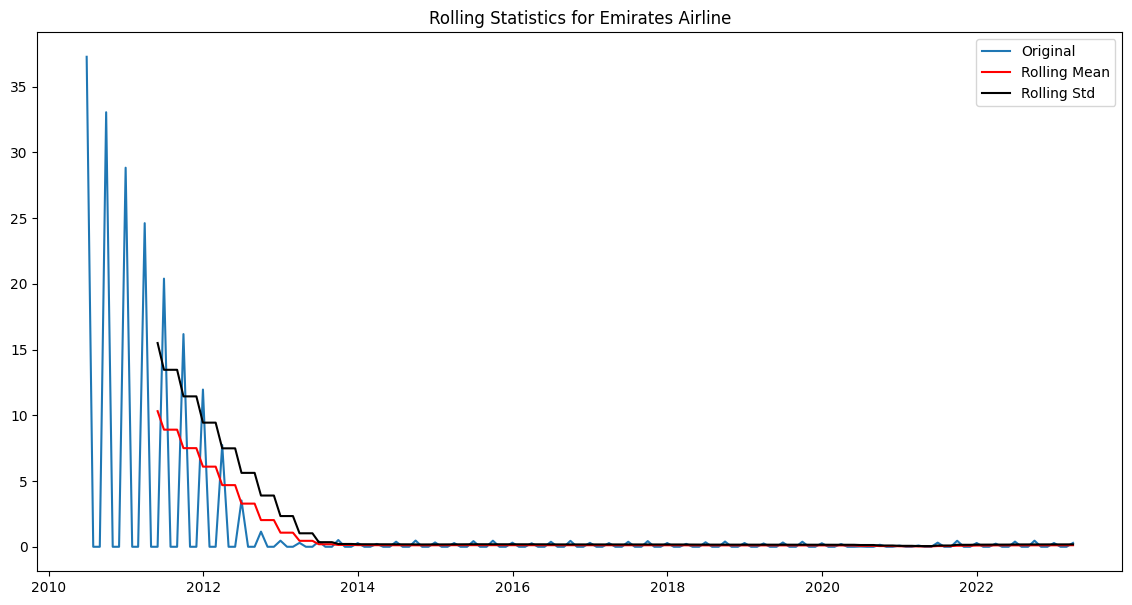

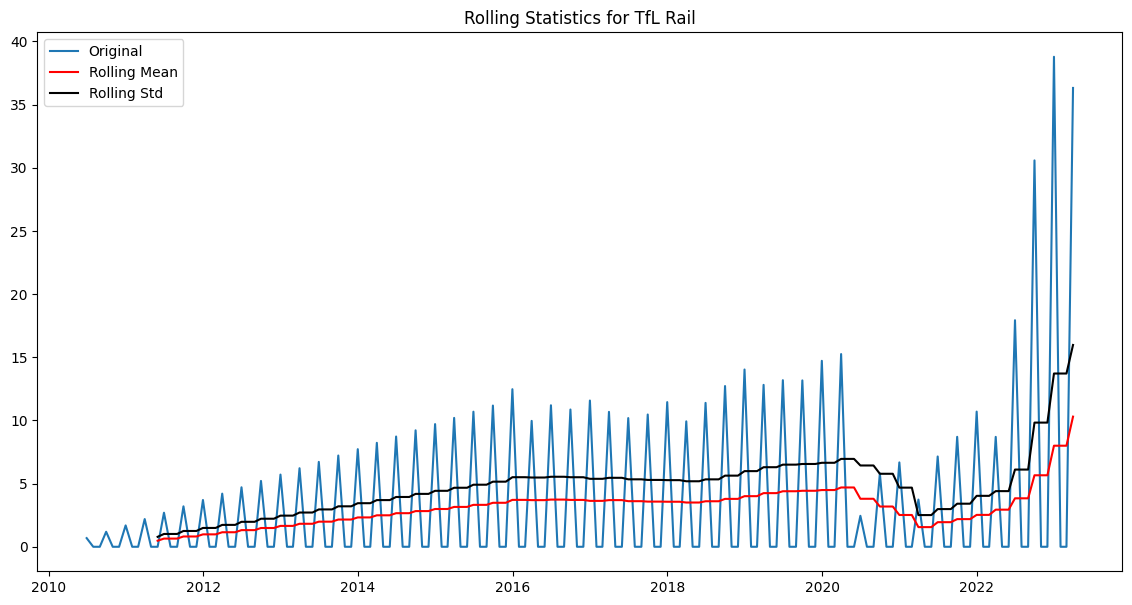

In [303]:
# Analyze trends and seasonality using rolling statistics
for journey_type in df['journey_type'].unique():
    journey_data = df[df['journey_type'] == journey_type]
    journey_data.set_index('report_date', inplace=True)
    journey_data = journey_data['journeys_millions'].resample('M').sum()

    rolling_mean = journey_data.rolling(window=12).mean()
    rolling_std = journey_data.rolling(window=12).std()

    plt.figure(figsize=(14, 7))
    plt.plot(journey_data, label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title(f'Rolling Statistics for {journey_type}')
    plt.legend(loc='best')
    plt.show()

**Machine Learning**

In [304]:
# Feature Engineering: Create lag features
df['month'] = df['report_date'].dt.month
df['year'] = df['report_date'].dt.year

In [305]:
# Create a pivot table to have a monthly time series
pivot_df = df.pivot_table(values='journeys_millions', index='report_date', columns='journey_type', aggfunc='sum')
pivot_df = pivot_df.asfreq('M').fillna(0)

In [306]:
print(pivot_df.head())

journey_type         Bus  Emirates Airline  Overground  TfL Rail      Tram  \
report_date                                                                  
2010-06-30    546.602626         37.279766    7.900709  0.685482  6.571696   
2010-07-31      0.000000          0.000000    0.000000  0.000000  0.000000   
2010-08-31      0.000000          0.000000    0.000000  0.000000  0.000000   
2010-09-30    519.658155         33.059955   12.402232  1.188402  6.177170   
2010-10-31      0.000000          0.000000    0.000000  0.000000  0.000000   

journey_type  Underground & DLR  
report_date                      
2010-06-30           277.204908  
2010-07-31             0.000000  
2010-08-31             0.000000  
2010-09-30           267.582706  
2010-10-31             0.000000  


In [307]:
# Create lag features
for i in range(1, 13):
    pivot_df[f'lag_{i}'] = pivot_df['Underground & DLR'].shift(i)

In [308]:
# Drop rows with NaN values due to lagging
pivot_df = pivot_df.dropna()

In [309]:
# Define features (X) and target (y)
X = pivot_df.drop(columns=['Underground & DLR'])
y = pivot_df['Underground & DLR']

In [310]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [311]:
# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Model: {model.__class__.__name__}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2 Score: {r2}')
    return model, y_pred, r2

In [312]:
# List of models to evaluate
models = [
    LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    DecisionTreeRegressor(),
    XGBRegressor(),
    CatBoostRegressor(verbose=0)
]

# Evaluate each model and select the best one based on R2 score
best_model = None
best_r2 = -np.inf
predictions = {}

for model in models:
    model_name = model.__class__.__name__
    print(f'\nEvaluating {model_name}...')
    evaluated_model, y_pred, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    predictions[model_name] = y_pred
    if r2 > best_r2:
        best_r2 = r2
        best_model = evaluated_model

print(f'\nBest model is {best_model.__class__.__name__} with R2 score: {best_r2}')


Evaluating LinearRegression...
Model: LinearRegression
MAE: 23.527091503025797
MSE: 1640.860975348475
RMSE: 40.50754220325488
R2 Score: 0.8465925561681253

Evaluating RandomForestRegressor...
Model: RandomForestRegressor
MAE: 16.12821958077033
MSE: 902.6341897205166
RMSE: 30.043871084141546
R2 Score: 0.9156108860893152

Evaluating GradientBoostingRegressor...
Model: GradientBoostingRegressor
MAE: 16.318008715425155
MSE: 910.2312969492732
RMSE: 30.170039724025443
R2 Score: 0.9149006170183888

Evaluating SVR...
Model: SVR
MAE: 59.438485593642305
MSE: 10730.130114280397
RMSE: 103.5863413500081
R2 Score: -0.0031817792885182605

Evaluating DecisionTreeRegressor...
Model: DecisionTreeRegressor
MAE: 35.53331013896552
MSE: 4197.881103540005
RMSE: 64.79105728061555
R2 Score: 0.60753152200025

Evaluating XGBRegressor...
Model: XGBRegressor
MAE: 36.88090201317491
MSE: 5107.607681342319
RMSE: 71.46752885991175
R2 Score: 0.5224793262425116

Evaluating CatBoostRegressor...
Model: CatBoostRegressor


In [313]:
# Hyperparameter tuning using GridSearchCV for the best model
if isinstance(best_model, GradientBoostingRegressor):
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
elif isinstance(best_model, RandomForestRegressor):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, None]
    }
elif isinstance(best_model, XGBRegressor):
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
elif isinstance(best_model, lgb.LGBMRegressor):
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50]
    }
elif isinstance(best_model, CatBoostRegressor):
    param_grid = {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [3, 5]
    }
else:
    param_grid = {}

if param_grid:
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f'\nBest parameters from GridSearchCV: {grid_search.best_params_}')

# Evaluate the best model from GridSearchCV
_, y_pred_best, _ = evaluate_model(best_model, X_train, y_train, X_test, y_test)



Best parameters from GridSearchCV: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}
Model: CatBoostRegressor
MAE: 13.373651261213729
MSE: 779.642089028834
RMSE: 27.922071718066228
R2 Score: 0.9271096687784559


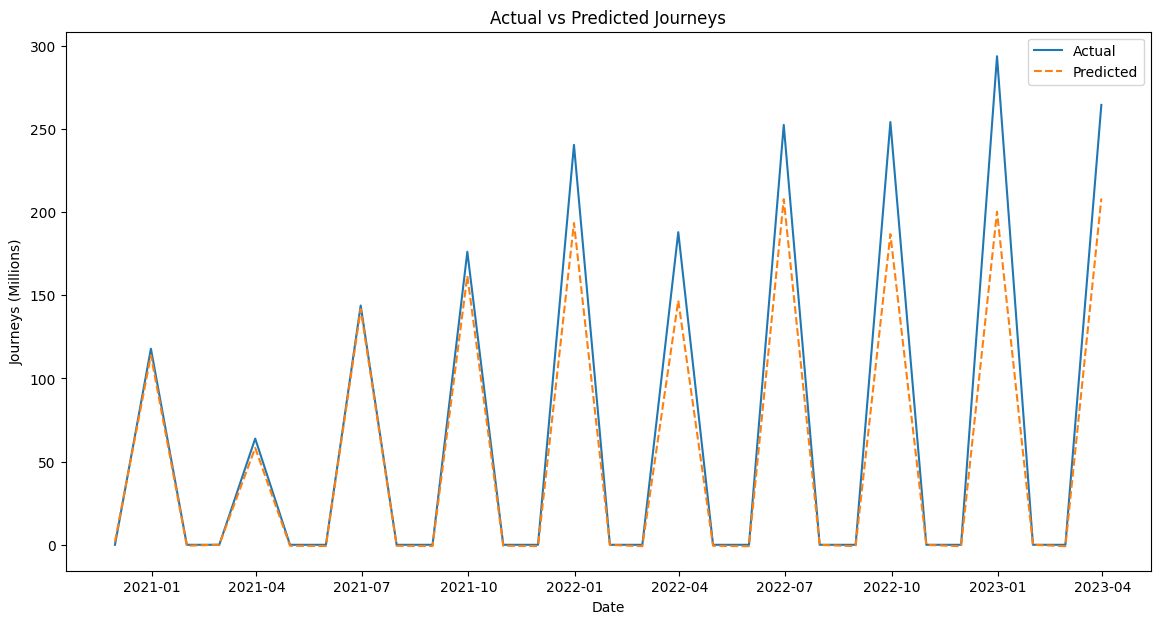

In [314]:
# Plot actual vs predicted values for the best model
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_best, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Journeys (Millions)')
plt.title('Actual vs Predicted Journeys')
plt.legend()
plt.show()

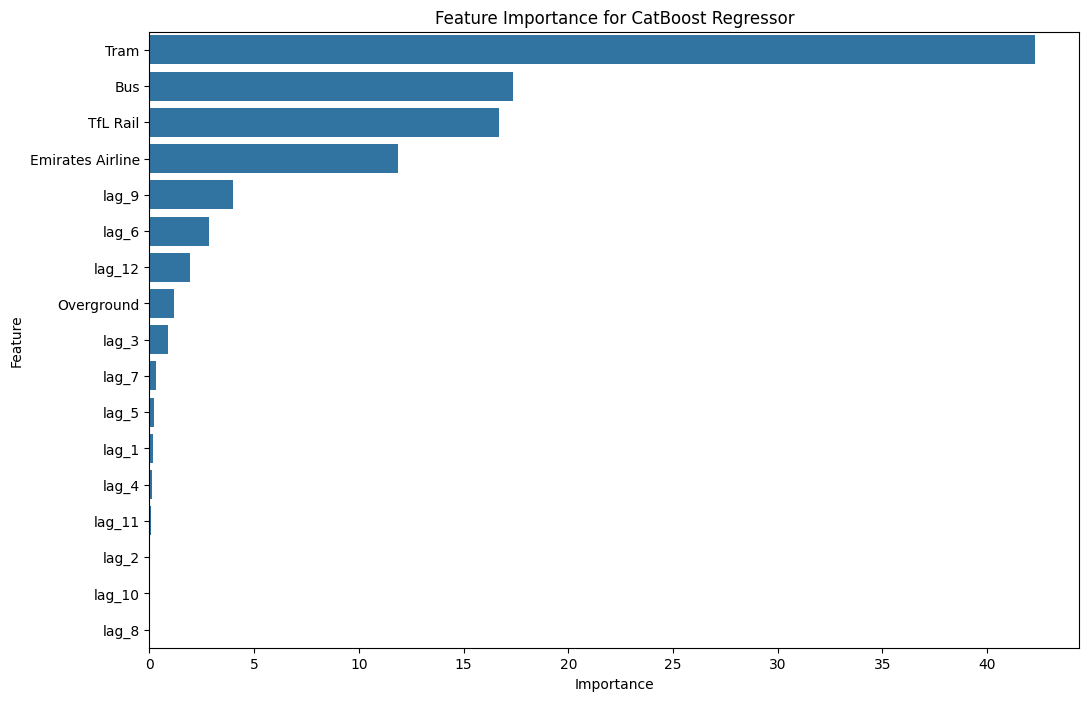

In [315]:
# Plot feature importance for CatBoost
if isinstance(best_model, CatBoostRegressor):
    feature_importances = best_model.get_feature_importance()
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for CatBoost Regressor')
    plt.show()